In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
df = pd.read_csv("dataframes/final_df.csv")
df.head()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345906,51.511963,-0.028211,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,0
1,345907,51.371636,-0.117621,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0
2,345908,51.514951,-0.072747,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
3,345909,51.519173,-0.262356,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,345910,51.565743,-0.136308,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


In [37]:
df.drop(['Car', 'Heavy_Vehicles',
       'Motorcycle', 'Other', 'Pedalcycle', 'casualty_age_0-23',
       'casualty_age_24-30', 'casualty_age_31-38', 'casualty_age_39-50',
       'casualty_age_50+'], axis=1)
print(df.columns)
borough_cols = [col for col in df.columns if col.startswith('borough_')]
df.drop(columns=borough_cols, inplace=True, errors='ignore')
df.head()

Index(['id', 'lat', 'lon', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'month', 'day_of_week', 'Car', 'Heavy_Vehicles',
     

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,2,0,0,0,0,0,1,0,0,0
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0,1,0
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,0,0,1,0,1,0,1,0,0,0
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,1,0,0,0,0,0,0,0,1,0
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,1,0,1,0,0,1,0,0,0,0


In [38]:
X = df.drop(columns=['severity', 'id'])
y = df['severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X.head()

(40500, 18)
(10126, 18)
(40500,)
(10126,)


,lat,lon,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,51.511963,-0.028211,1,0,0,0,1,3,2,0,0,0,0,0,1,0,0,0
1,51.371636,-0.117621,0,0,0,1,1,2,2,0,0,0,0,0,0,0,1,0
2,51.514951,-0.072747,0,0,0,1,1,2,0,0,1,0,1,0,1,0,0,0
3,51.519173,-0.262356,0,1,0,0,1,3,1,0,0,0,0,0,0,0,1,0
4,51.565743,-0.136308,0,1,0,0,1,3,1,0,1,0,0,1,0,0,0,0


In [39]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV
X_train_res, y_train_res = X_train.copy(), y_train.copy()

adasyn_test = ADASYN(random_state=42)
X_test_res, y_test_res = adasyn_test.fit_resample(X_test, y_test)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_res)

param_grid = {
            'learning_rate': [0.2, 0.3],
            'max_depth': [9, 11],
            'subsample': [0.8, 1.0],  
     
        }
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)), 
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)
print("Initiating Grid Search")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)
shap_xgb_model = grid_search.best_estimator_
print("\n===== Grid Search Results =====")
print("Best Parameters:", grid_search.best_params_)
print("Best F1 (CV):", grid_search.best_score_)

Initiating Grid Search
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ......learning_rate=0.2, max_depth=9, subsample=1.0; total time=   0.9s
[CV] END ......learning_rate=0.2, max_depth=9, subsample=1.0; total time=   0.9s
[CV] END ......learning_rate=0.2, max_depth=9, subsample=1.0; total time=   1.0s
[CV] END ......learning_rate=0.2, max_depth=9, subsample=0.8; total time=   1.1s
[CV] END ......learning_rate=0.2, max_depth=9, subsample=0.8; total time=   1.1s
[CV] END ......learning_rate=0.2, max_depth=9, subsample=0.8; total time=   1.1s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=1.0; total time=   1.3s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=0.8; total time=   1.4s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=0.8; total time=   1.5s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=0.8; total time=   1.5s
[CV] END ......learning_rate=0.3, max_depth=9, subsample=0.8; total time=   1.0s
[CV] END ......learning_ra

In [40]:
y_pred = shap_xgb_model.predict(X_test_res)

              precision    recall  f1-score   support

      Slight      0.399     0.981     0.568      8547
     Serious      0.677     0.342     0.454      8682
       Fatal      0.985     0.046     0.088      8559

    accuracy                          0.456     25788
   macro avg      0.687     0.456     0.370     25788
weighted avg      0.687     0.456     0.370     25788



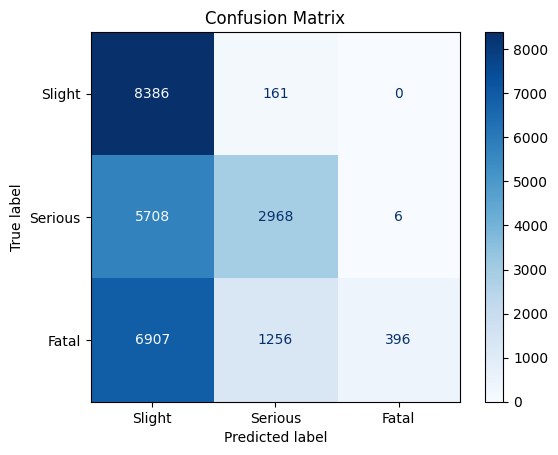

In [41]:
print(classification_report(
    y_test_res, y_pred,
    target_names=['Slight', 'Serious', 'Fatal'],
    digits=3
))
cm = confusion_matrix(y_test_res, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Slight','Serious','Fatal'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix")
plt.show()

In [44]:
# Fits the explainer
explainer = shap.Explainer(shap_xgb_model.predict, X_test_res)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_res)

PermutationExplainer explainer:  12%|█▏        | 3106/25788 [05:00<38:00,  9.94it/s]  


KeyboardInterrupt: 